In [1]:
import numpy as np
if not hasattr(__builtins__, 'object'):
    np.object = object

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

def load_image_mask_pairs(image_dir, mask_dir, img_size=(256, 256)):
    mask_files = sorted(os.listdir(mask_dir))
    image_files = sorted(os.listdir(image_dir))

    masks = []
    images = []

    for img_name, mask_name in zip(image_files, mask_files):
        mask_path = os.path.join(mask_dir, mask_name)
        img_path = os.path.join(image_dir, img_name)

        image = load_img(img_path, target_size=img_size)
        image = img_to_array(image) / 255.0

        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
        mask = img_to_array(mask) / 255.0
        mask = (mask > 0.5).astype(np.float32)

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

base_path = os.path.join('C:', os.sep, 'Users', 'USER', 'python', 'pj3', 'ETT-v3', 'Fold5')

train_images, train_masks = load_image_mask_pairs(
    os.path.join(base_path, 'train'),
    os.path.join(base_path, 'trainannot')
)

val_images, val_masks = load_image_mask_pairs(
    os.path.join(base_path, 'val'),
    os.path.join(base_path, 'valannot')
)

test_images, test_masks = load_image_mask_pairs(
    os.path.join(base_path, 'test'),
    os.path.join(base_path, 'testannot')
)

print(len(train_images), len(train_masks))
print(len(val_images), len(val_masks))

from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(            
    width_shift_range=0.05,     #左右隨機平移
    rotation_range=10,   #輕微旋轉  
    height_shift_range=0.05,    #上下隨機平移            
    zoom_range=0.05,    #隨機裁切與縮放 
    shear_range=0.05,       #剪切變形範圍  
    horizontal_flip=True,    #水平翻轉          
    fill_mode='nearest'
)

def augment_dataset(images, masks, augment_times=2, batch_size=8):
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    image_gen = image_datagen.flow(images, batch_size=batch_size, seed=1)
    mask_gen = mask_datagen.flow(masks, batch_size=batch_size, seed=1)

    augmented_images = []
    augmented_masks = []

    steps = (len(images) * augment_times) // batch_size

    for _ in range(steps):
        img_batch = next(image_gen)
        mask_batch = next(mask_gen)
        augmented_images.extend(img_batch)
        augmented_masks.extend(mask_batch)

    return np.array(augmented_images), np.array(augmented_masks)


aug_train_images, aug_train_masks = augment_dataset(train_images, train_masks, augment_times=2)

train_images = np.concatenate([train_images, aug_train_images])
train_masks = np.concatenate([train_masks, aug_train_masks])

print((train_images.shape),(test_images.shape))

import tensorflow as tf

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true + y_pred > 0, tf.float32))
    return intersection / (union + tf.keras.backend.epsilon())

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import LearningRateScheduler
from keras import backend as keras


def segnet_model(input_size=(256, 256, 3)):
    inputs = Input(shape=input_size)

    # Encoder
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # 128x128

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # 64x64

    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # 32x32

    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # 16x16

    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # 8x8

    # Decoder
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', iou])
    return model




from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

Fold_number = 5

model = segnet_model()
model_checkpoint = ModelCheckpoint(
    f'ETT_segnet_Fold{Fold_number}.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_model = model.fit(
    train_images, train_masks,
    batch_size=2,
    epochs=30,
    validation_data=(val_images, val_masks),
    callbacks=[model_checkpoint, early_stop]
)

C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


285 285
48 48
(850, 256, 256, 3) (48, 256, 256, 3)
Epoch 1/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9748 - iou: 0.0011 - loss: 0.1116      
Epoch 1: val_loss improved from inf to 0.02644, saving model to ETT_segnet_Fold5.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 0.9748 - iou: 0.0011 - loss: 0.1115 - val_accuracy: 0.9924 - val_iou: 0.0029 - val_loss: 0.0264
Epoch 2/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9888 - iou: 0.0026 - loss: 0.0286  
Epoch 2: val_loss improved from 0.02644 to 0.01597, saving model to ETT_segnet_Fold5.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - accuracy: 0.9888 - iou: 0.0026 - loss: 0.0285 - val_accuracy: 0.9925 - val_iou: 0.0052 - val_loss: 0.0160
Epoch 3/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9894 - iou: 0.0050 - loss: 0.0231  
Epoch 3: val_loss did not improve from 0.01597
425/425 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.9894 - iou: 0.0050 - loss: 0.0231 - val_accuracy: 0.9922 - va

C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 106 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step   
📊 Evaluation Results
IoU: 0.7497
Avg Vertical Error (cm): 0.1036
Acc ≤ 0.5 cm: 97.92%
Acc ≤ 1.0 cm: 100.00%


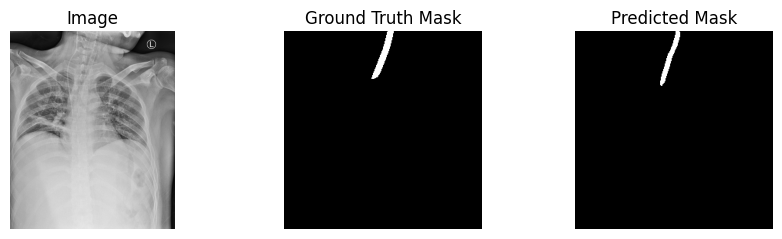

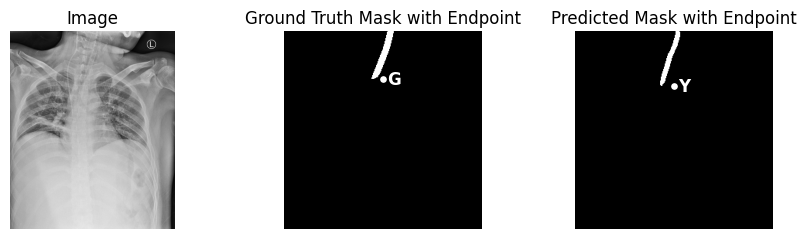

In [2]:
import os, numpy as np, tensorflow as tf, cv2
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

Fold_number = 5
PIXELS_PER_CM = 72

# ========================
# 1. 模型預測與績效計算
# ========================
# 載入測試資料
test_images, test_masks = load_image_mask_pairs(
    os.path.join(f'ETT-v3/Fold{Fold_number}', 'test'),
    os.path.join(f'ETT-v3/Fold{Fold_number}', 'testannot')
)

# 提前準備圖像檔案路徑（用於可視化）
test_image_dir = f'ETT-v3/Fold{Fold_number}/test'
test_image_filenames = sorted(os.listdir(test_image_dir))
test_image_paths = [os.path.join(test_image_dir, name) for name in test_image_filenames]

# 模型預測
model = segnet_model()
model.load_weights(f'ETT_segnet_Fold{Fold_number}.keras')
results = model.predict(test_images, batch_size=8, verbose=1)
results = (results > 0.5).astype(int)

# 儲存預測遮罩
def labelVisualize(num_class, color_dict, img):
    img = img[:, :, 0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i, :] = color_dict[i]
    return img_out / 255

def saveResult(save_path, npyfile, flag_multi_class=False, num_class=2):
    os.makedirs(save_path, exist_ok=True)
    for i, item in enumerate(npyfile):
        img = labelVisualize(num_class, np.array([[0, 0, 0], [255, 255, 255]]), item) if flag_multi_class else item[:, :, 0]
        img = (img * 255).astype(np.uint8)
        img = Image.fromarray(img).convert('RGB')
        img.save(os.path.join(save_path, f"{i}_predict.jpeg"), 'JPEG')

saveResult(f'ETT/Fold{Fold_number}/predannot_segnet/', results)


# 評估指標計算
true_images = test_masks
pred_images = results

def get_lowest_y_coordinate(mask):
    for idx in range(mask.shape[0] - 1, -1, -1):
        if np.any(mask[idx]):
            return idx
    return 0

def extract_lowest_y_coordinates(gt_list, pred_list):
    gt_coords = [get_lowest_y_coordinate(gt) for gt in gt_list]
    pred_coords = [get_lowest_y_coordinate(pd) for pd in pred_list]
    return tf.constant(gt_coords, dtype=tf.float32), tf.constant(pred_coords, dtype=tf.float32)

def compute_iou(gt_mask, pred_mask):
    metric = tf.keras.metrics.MeanIoU(num_classes=2)
    metric.update_state(gt_mask, pred_mask)
    return metric.result().numpy()

def mean_vertical_error(gt_list, pred_list):
    actual_y, predicted_y = extract_lowest_y_coordinates(gt_list, pred_list)
    return tf.reduce_mean(tf.abs(predicted_y - actual_y)) / PIXELS_PER_CM

def precision_within_threshold(gt_list, pred_list, threshold):
    actual_y, predicted_y = extract_lowest_y_coordinates(gt_list, pred_list)
    acc = tf.reduce_mean(tf.cast(tf.abs(predicted_y - actual_y) <= threshold, tf.float32)) * 100.0
    return acc.numpy()

def precision_within_half_cm(gt, pd): return precision_within_threshold(gt, pd, 36)
def precision_within_one_cm(gt, pd): return precision_within_threshold(gt, pd, 72)

print("📊 Evaluation Results")
print(f"IoU: {compute_iou(true_images, pred_images):.4f}")
print(f"Avg Vertical Error (cm): {mean_vertical_error(true_images, pred_images).numpy():.4f}")
print(f"Acc ≤ 0.5 cm: {precision_within_half_cm(true_images, pred_images):.2f}%")
print(f"Acc ≤ 1.0 cm: {precision_within_one_cm(true_images, pred_images):.2f}%")

# ========================
# 2. 圖像可視化（未標記端點）
# ========================
def preprocess_for_display(mask_array, cmap='gray'):
    plt.imshow(mask_array.squeeze(), cmap=cmap)
    plt.axis('off')

i = 0  # 預覽第幾張圖

plt.figure(figsize=(9, 2.5))
plt.subplot(131)
plt.title("Image")
plt.imshow(Image.open(test_image_paths[i]), cmap='gray') 
plt.axis('off')

plt.subplot(132)
plt.title("Ground Truth Mask")
preprocess_for_display(test_masks[i])

plt.subplot(133)
plt.title("Predicted Mask")
preprocess_for_display(results[i])

plt.tight_layout()
plt.show()

# ========================
# 3. 圖像可視化（已標記端點）
# ========================
def show_image_with_endpoint_bw(mask_array, title, label=None):
    img = mask_array.squeeze()
    y = get_lowest_y_coordinate(img)
    plt.imshow(img, cmap='gray')  # 使用灰階顯示
    if label:
        x = img.shape[1] // 2
        plt.scatter(x, y, c='white', s=40, edgecolors='black', linewidths=1.5)  # 白點黑邊標記
        plt.text(x + 5, y, label, color='white',  # ✅ 改成白字
                 fontsize=12, fontweight='bold', va='center')
    plt.title(title)
    plt.axis('off')


plt.figure(figsize=(9, 2.5))
plt.subplot(131)
plt.imshow(Image.open(test_image_paths[i]), cmap='gray')
plt.title('Image')
plt.axis('off')

plt.subplot(132)
show_image_with_endpoint_bw(test_masks[i], "Ground Truth Mask with Endpoint", label="G")

plt.subplot(133)
show_image_with_endpoint_bw(results[i], "Predicted Mask with Endpoint", label="Y")

plt.tight_layout()
plt.show()

